<a href="https://colab.research.google.com/github/Akash-088/Brain-Tumor-Detection-/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install split-folders

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.listdir("/content/drive/MyDrive/data")

['Testing', 'Training']

In [9]:
import pathlib
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_data_dir = "/content/drive/MyDrive/data/Training"
testing_data_dir = "/content/drive/MyDrive/data/Testing"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    training_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    testing_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [37]:
# class BrainTumorCNN(nn.Module):
#     def __init__(self):
#         super(BrainTumorCNN, self).__init__()
#         self.resnet = torchvision.models.resnet18(pretrained=True)

#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)

#     def forward(self, x):
#         return self.resnet(x)

# model = BrainTumorCNN()

# print(model)

In [38]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

model.save("brain_tumor_model.h5")

from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/Colab NoteBooks/brain_tumor_model.h5'
model.save(model_path)
print(f"Model saved to {model_path}")

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.6071 - loss: 0.9921 - val_accuracy: 0.7945 - val_loss: 0.4851
Epoch 2/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3:55 1s/step - accuracy: 0.9062 - loss: 0.3321

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.9062 - loss: 0.3321 - val_accuracy: 0.7969 - val_loss: 0.4886
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.8726 - loss: 0.3684 - val_accuracy: 0.8938 - val_loss: 0.2781
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9375 - loss: 0.1634 - val_accuracy: 0.8961 - val_loss: 0.2799
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9197 - loss: 0.2261 - val_accuracy: 0.9031 - val_loss: 0.2237
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9375 - loss: 0.2024 - val_accuracy: 0.9094 - val_loss: 0.2295
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.9473 - loss: 0.1455 - val_accuracy: 0.9367 - val_loss: 0.1746
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.9062 - loss: 0.2283 - val_accuracy: 0.9375 - val_loss: 0.1683
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.9615 - loss: 0.1121 - val_accuracy:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/Colab NoteBooks/brain_tumor_model.h5


In [17]:
import pathlib

data_dir = pathlib.Path("/content/drive/MyDrive/data")

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.ImageFolder(data_dir / 'Training', transform=transform)
val_set = torchvision.datasets.ImageFolder(data_dir / 'Testing', transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

print("Classes:", train_set.classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [18]:
print(train_set)

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /content/drive/MyDrive/data/Training
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


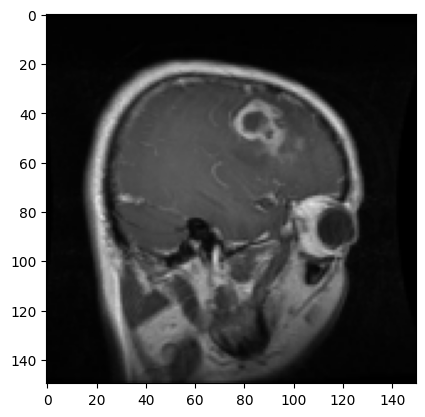

In [19]:
img, label = train_set[1000]
plt.imshow(img.permute(1,2,0))

In [20]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [21]:
next(iter(val_loader))[0].shape

torch.Size([64, 3, 150, 150])

In [22]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.leakyRelu = nn.LeakyReLU()
        self.fc1 = nn.Linear(128 * 5 * 5, 1024)
        self.fc2 = nn.Linear(1024, 4)

    def forward(self, x):
        out = self.leakyRelu(self.cnv1(x))
        out = self.maxpool1(out)

        out = self.leakyRelu(self.cnv2(out))
        out = self.maxpool2(out)

        out = self.leakyRelu(self.cnv3(out))
        out = self.maxpool3(out)

        out = self.leakyRelu(self.cnv4(out))
        out = self.maxpool4(out)

        out = out.view(out.size(0), -1)

        out = self.leakyRelu(self.fc1(out))
        out = self.fc2(out)

        return out

In [23]:
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [24]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    outputs = model(images)
    loss = error(outputs, labels)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    correct+=(predicted==labels).sum()


  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Acciracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))

Loss in Iteration: 0 : 1.3844902515411377
Loss in Iteration: 1 : 1.385833501815796
Loss in Iteration: 2 : 1.3955016136169434
Loss in Iteration: 3 : 1.362380027770996
Loss in Iteration: 4 : 1.2807447910308838
Loss in Iteration: 5 : 1.509668231010437
Loss in Iteration: 6 : 1.210381031036377
Loss in Iteration: 7 : 1.3218214511871338
Loss in Iteration: 8 : 1.318561315536499
Loss in Iteration: 9 : 1.3346701860427856
Loss in Iteration: 10 : 1.2810966968536377
Loss in Iteration: 11 : 1.2475941181182861
Loss in Iteration: 12 : 1.4824081659317017
Loss in Iteration: 13 : 1.1524583101272583
Loss in Iteration: 14 : 1.4477975368499756
Loss in Iteration: 15 : 1.2453908920288086
Loss in Iteration: 16 : 1.2007173299789429
Loss in Iteration: 17 : 1.1688148975372314
Loss in Iteration: 18 : 1.335231900215149
Loss in Iteration: 19 : 1.1822504997253418
Loss in Iteration: 20 : 1.075333833694458
Loss in Iteration: 21 : 1.0034984350204468
Loss in Iteration: 22 : 1.147474765777588
Loss in Iteration: 23 : 0.974

In [25]:
train_loss_list

[0.870501332812839,
 0.459525327053335,
 0.29710005049904187,
 0.20570336344341436,
 0.13610628791567353,
 0.10528037645336655,
 0.07735933467952741,
 0.0656993898925268,
 0.04904033505461282,
 0.06360175643219716]

In [26]:
val_loss_list

[0.7047069498470852,
 0.49580604547546026,
 0.33864166481154306,
 0.26203602694329764,
 0.2755477318451518,
 0.157285626268103,
 0.199808345398023,
 0.1812954828852699,
 0.23177360814242137,
 0.13896598214549677]

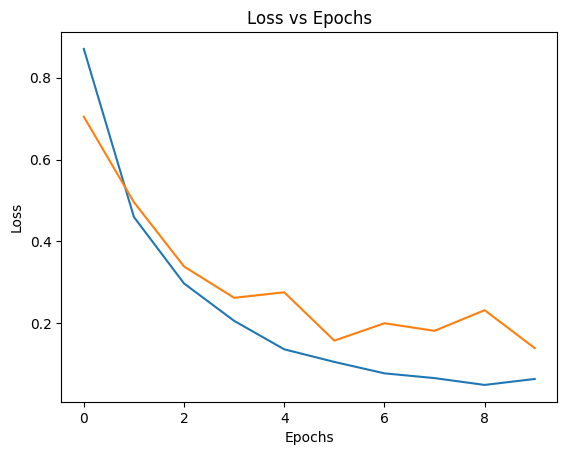

In [48]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)

In [28]:
accuracy_list

[tensor(72.0061),
 tensor(79.7864),
 tensor(87.2616),
 tensor(90.6179),
 tensor(90.5416),
 tensor(94.7368),
 tensor(93.9741),
 tensor(94.5080),
 tensor(92.6773),
 tensor(96.1861)]

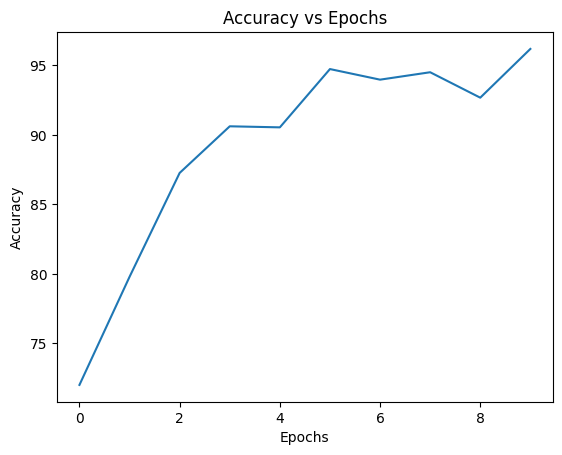

In [47]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.plot(range(num_epochs), accuracy_list)

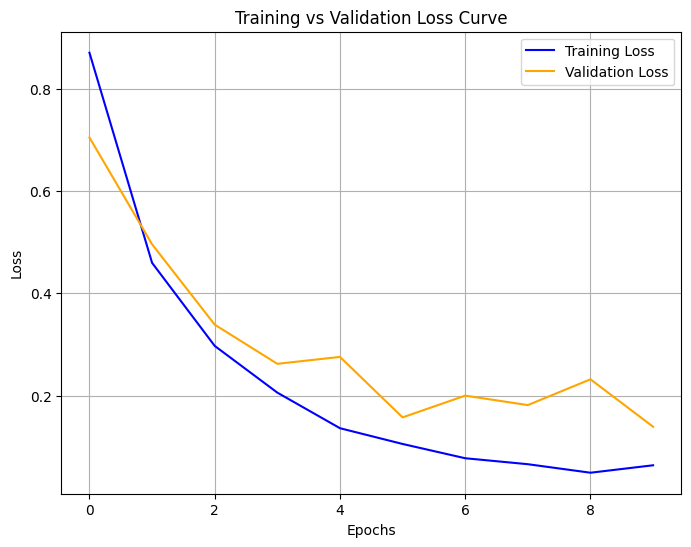

In [30]:
import matplotlib.pyplot as plt

epochs = range(len(train_loss_list))

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_list, label='Training Loss', color='blue')
plt.plot(epochs, val_loss_list, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.show()


Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.88      0.93       300
  meningioma       0.92      0.95      0.93       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



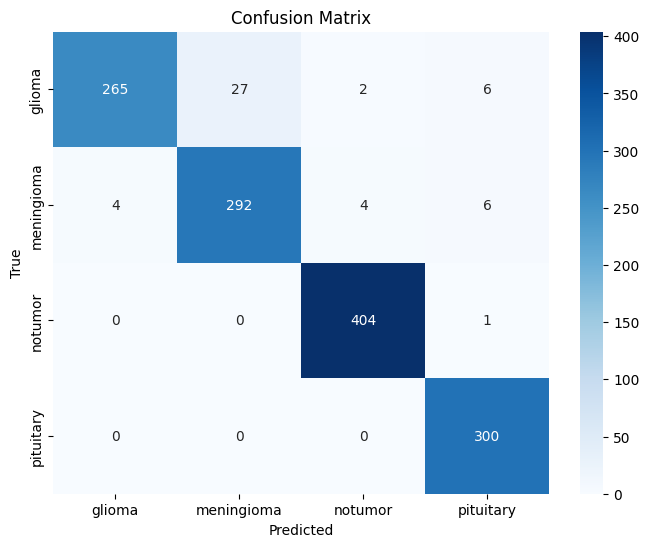

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

true_labels = []
pred_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for images, labels in val_loader:  # replace with test_loader if needed
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=val_set.classes))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_set.classes, yticklabels=val_set.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Classification Report:


Accuracy: 0.9619


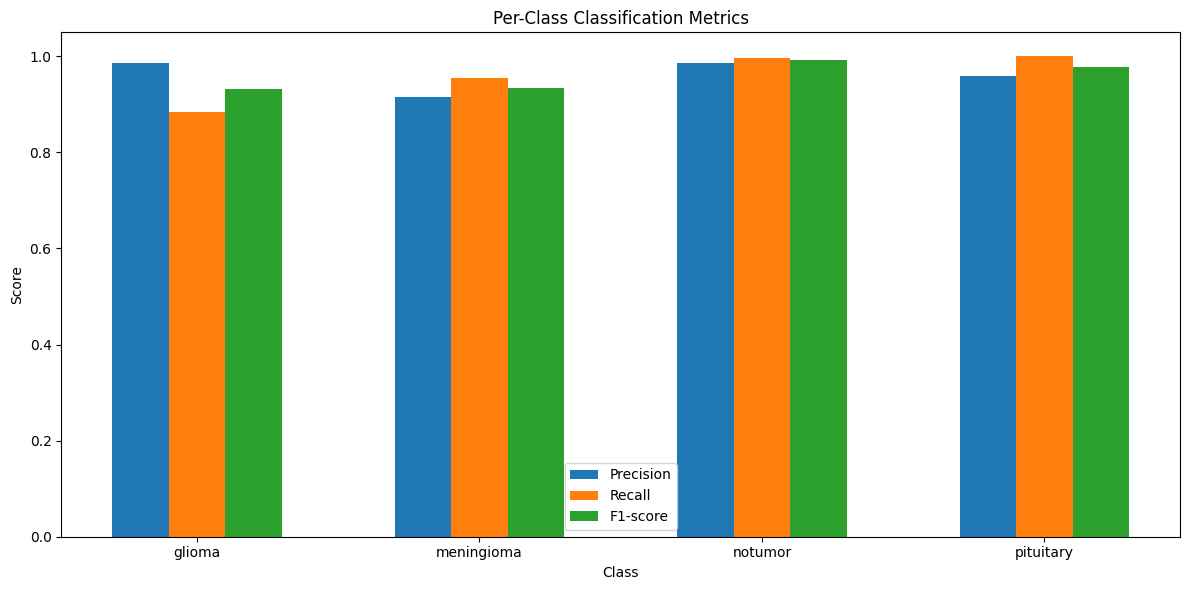

In [44]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

print("Classification Report:\n")
report = classification_report(true_labels, pred_labels, target_names=val_set.classes, output_dict=True)

accuracy = np.mean(np.array(true_labels) == np.array(pred_labels))
print(f"\nAccuracy: {accuracy:.4f}")

class_labels = val_set.classes
precision = [report[label]["precision"] for label in class_labels]
recall = [report[label]["recall"] for label in class_labels]
f1_score = [report[label]["f1-score"] for label in class_labels]

x = np.arange(len(class_labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-score')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Per-Class Classification Metrics')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.set_ylim(0, 1.05)
ax.legend()

plt.tight_layout()
plt.show()


In [33]:
print(model)

CNNModel(
  (cnv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (leakyRelu): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=3200, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
)


Text(0.5, 1.0, '0')

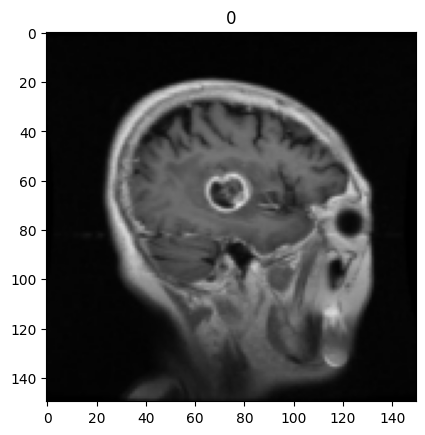

In [69]:
img, label = val_set[256]
plt.imshow(img.permute(1,2,0))
plt.title(label)

In [70]:
image = img.unsqueeze(0)

with torch.no_grad():
  output = model(image)

_, pred = torch.max(output, 1)
predicted_class = train_set.classes[pred.item()]
print("Predicted Output:", pred.item())
print("Predicted Class:", predicted_class)

Predicted Output: 0
Predicted Class: glioma
